# Introduction
__Data Sources__

The data includes the Austin Animal Center's intake data extracted from the Socrata Open Data API. The data date ranges from Oct, 2013 to March, 2018.

__Why do I choose this topic?__

According the dataset, there are major 4 outcomes the animal can end up with: adoption, return to the owner, transfer to other shelters, and died(including Euthanasia). The final outcome of the animal is determined by a lot factors: animal type, animal sex, animal breed and etc. The topic is chosen for the benefit of the animals. It can be really helpful to know to forecast the final outcome of the animal. According to the prediction, the shelter can plan accordingly and allocate resouces. 

__Description of the dataset__

There are major two parts of take: 1. information of the intake: this includes a bundle of features describing the situation when the animal is intaken. 2. information of the outcome: this includes a bundle of feature on the animal on outcome date. In the model, I will mainly use the intake variables, since we will only know those when trying to make prediction. The only exception is the outcome age, outcome sex, outcome month, outcome year. It will help us to find what's the best age/sex/time for a animal to be adopted. When predicting, we just replace those variables with current age/sex/time.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import warnings
#import all algorithm packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading the data

We will load the data from the csv file. There are 9 outcome types in the file. There are 79k rows, and 41 columns in the data. This is relative small for a complex machine learning project(eg. neutral network with thousands of layers). However, the data records should be enough for a lot of machine learning algorithm to be effective.

Note that there are actually 9 categories in the outcome type variable. However, values other than the major 4 categories(adoption, return to owner, transfer, die) only accounted for less than 0.3% of the total dataset. We will simply remove these 200 records in the dataset so that we can focus on the major categories. The new dataset's shape is (79422, 42). We name the new target variable as "target".

In [2]:
df = pd.read_csv("aac_intakes_outcomes.csv", header = 0)
print "The original shape of the data is ", df.shape

The original shape of the data is  (79672, 41)


In [9]:
print df.groupby(["outcome_type"])["outcome_type"].count().sort_values(ascending = False)
final_df = df.loc[df.outcome_type.isin(["Adoption","Transfer","Return to Owner","Euthanasia","Died","Disposal"]), ]
def target(x):
    if x in ["Euthanasia","Died","Disposal"]: 
        return "Died" 
    else: 
        return x
    
final_df.loc[:,"target"]  = final_df.outcome_type.apply(lambda x: target(x))
print "The new dataset's shape is", final_df.shape

outcome_type
Adoption           33594
Transfer           23799
Return to Owner    14791
Euthanasia          6244
Died                 690
Disposal             304
Rto-Adopt            179
Missing               46
Relocate              15
Name: outcome_type, dtype: int64
The new dataset's shape is (79422, 42)


In [7]:
print df.groupby(["outcome_type"])["outcome_type"].count().sort_values(ascending = False)
final_df =df.loc[df.outcome_type.isin(["Adoption","Transfer","Return to Owner","Euthanasia","Died","Disposal"]), ]
def target(x):
    if x in ["Euthanasia","Died","Disposal","Transfer"]: 
        return 0
    else: 
        return 1
    
final_df.loc[:,"target"]  = final_df.outcome_type.apply(lambda x: target(x))
print "The new dataset's shape is", final_df.shape

outcome_type
Adoption           33594
Transfer           23799
Return to Owner    14791
Euthanasia          6244
Died                 690
Disposal             304
Rto-Adopt            179
Missing               46
Relocate              15
Name: outcome_type, dtype: int64
The new dataset's shape is (79422, 42)


In [8]:
final_df.to_csv('input_data.csv')

# Data Transform

Before building models, we need to transform the feature to appropriate format. The following features are manipulated and converted to binary variables for model training:

1. Sex upon outcome: We can clearly see that neutered males and spayed females are much more likely to be adopted than other sex.
2. Animal type: Cats are more likely to be transfer than dogs
3. Intake condition: if the animal is sick or injure when intaking, it is much likely to die
4. Intake type: when the animal comes from Euthansia request or wildllife, it is very likely to die. If it comes from public assistant, it is more likely to be returned to owner. If it is owner surrendered, then the animal is more likely to be adopt.
5. Breed: we have more 1000 breed types for dogs and 100 breed types for cats. Obviously we cannot take all breed types into model. After some exploration anaysis, I decide to take only the top 30 dogs and top 20 cat breed. Usually, the more popular the breed, the higher the adoption rate.
6. Color: There are more 200 colors in the data set. We transformed it to four major types: "Black", "Dark color", "Light color", "muti-color"

## Sex_upon_outcome, animal_type, intake_condition, intake_type

In [10]:
#final_df.loc[,"avg_column"] = 1
def get_df(input_x, df = final_df):
    df.loc[:,"count_column"] = 1
    df.loc[: ,"avg_column"] = 1
    #print df.loc['avg_column']
    new_df = df.groupby([input_x,"target"]).agg({"count_column":'count', 'avg_column':'count'})
    new_df["count_column"] = new_df.groupby(level=0).transform(lambda x: x/x.sum())
    new_df.reset_index(inplace = True)
    return new_df

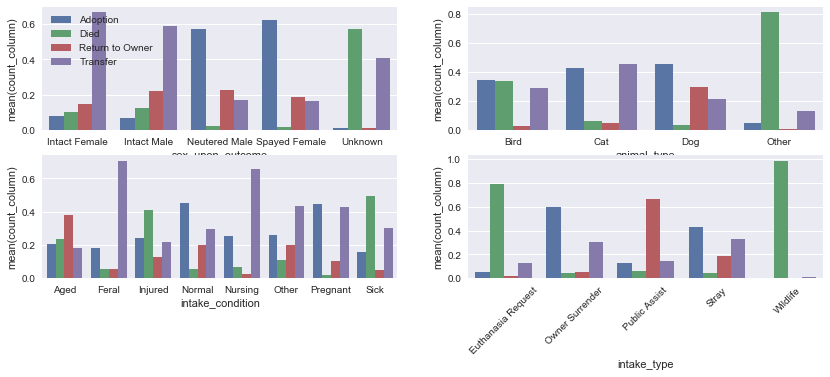

In [11]:
f, axes = plt.subplots(2, 2, figsize=(14, 5), sharex=False)
for i,c in enumerate(['sex_upon_outcome','animal_type','intake_condition','intake_type']):
    ax_x = i/2
    ax_y = i%2
    new_df = get_df(c, df = final_df)
    sns.barplot(x = c, y = "count_column", hue = "target", data= new_df, ax=axes[ax_x][ax_y])
    axes[ax_x][ax_y].legend_.remove()
plt.xticks(rotation=45)
axes[0][0].legend()

## TOP 30 dogs

In [12]:
final_df['breed_group'] = final_df['breed']
dog_breed = final_df.loc[final_df.animal_type == 'Dog','breed']
replace_f = lambda x: str(x).replace(' Mix',"")
v_replace_f = np.vectorize(replace_f)
dog_breed = np.unique(v_replace_f(dog_breed))
dog_breed.sort()
dog_group = {}
current_group = dog_breed[0]
for d in dog_breed:
    if d.startswith(current_group):
        pass
    else:
        current_group = d
    dog_group[d] = current_group[:]
dog_breed_df = final_df.loc[final_df.animal_type == 'Dog',['breed','target','age_upon_outcome']]
dog_breed_df['breed'] = dog_breed_df['breed'].apply(lambda x: dog_group[replace_f(x)])
Top30dogs = dog_breed_df['breed'].value_counts().index[:30]
def transform_dog_breed(x, d):
    try:
        if dog_group[replace_f(x)] == d: 
            return 1 
        else: 
            return 0
    except:
        return 0
for d in Top30dogs:
    final_df.loc[:, 'dogbreed_' + d] = final_df['breed'].apply(transform_dog_breed,d = d)

## TOP 20 Cats

In [13]:
cat_breed = final_df.loc[final_df.animal_type == 'Cat','breed']
replace_f = lambda x: str(x).replace(' Mix',"")
v_replace_f = np.vectorize(replace_f)
cat_breed = np.unique(v_replace_f(cat_breed))
cat_breed.sort()
cat_group = {}
current_group = cat_breed[0]

In [14]:
for c in cat_breed:
    if c.startswith(current_group):
        pass
    else:
        current_group = c
    cat_group[c] = current_group[:]

In [15]:
cat_breed_df = final_df.loc[final_df.animal_type == 'Cat',['breed','target','age_upon_outcome']]
cat_breed_df['breed'] = cat_breed_df['breed'].apply(lambda x: cat_group[replace_f(x)])
cat_breed_df['breed'].value_counts().sort_values(ascending = False)
Top20cats = cat_breed_df['breed'].value_counts().index[:30]
def transform_cat_breed(x, d):
    try:
        if cat_group[replace_f(x)] == d: 
            return 1 
        else: 
            return 0
    except:
        return 0
for d in Top20cats:
    final_df.loc[:, 'catbreed_' + d] = final_df['breed'].apply(transform_cat_breed,d = d)

## Colors

In [16]:
color_list = ["Black", "Dark color", "Light color", "muti-color"]
def transform_color(x, d):
    if x == "Black" and d == "Black":
        return 1
    elif ("Tan" in x or "Brown" in x or "Black" in x or "Black" in x) and "White" not in x and d == "Dark Color":
        return 1
    elif "White" in x and d == "Light color":
        return 1
    elif "/" in x and d == "muti-color":
        return 1
    else:
        return 0


In [17]:
for co in color_list:
    final_df.loc[:, 'color' + co] = final_df['color'].apply(transform_color,d = co)

Finally, we put everything together and get the training and testing dataset

In [18]:
dummies = pd.get_dummies(final_df[['sex_upon_outcome','animal_type','intake_condition','intake_type']], drop_first=True)
final_df = pd.concat([final_df, dummies], axis = 1)
all_var = ['age_upon_outcome_(years)','outcome_hour','outcome_month'] + list(dummies.columns) + ['color' + co for co in color_list] + ['catbreed_' + d for d in Top20cats] + ['dogbreed_' + d for d in Top30dogs]
X_train, X_test, y_train, y_test = train_test_split(final_df[all_var], final_df['target'], test_size=0.33, random_state=42)

# Model Training

## Set base model

To begin the model training, we start with a base model set. Five models are going to be trained without any parameter tuning or optimization. There are two goals here: 1. we can easily identify the best algorithm for this data and get an general idea of the training time. 2. The final model has to have better performance than the base model set in this section.

To evaluate the model, I choose the weighted F1 score as the metric since it consider both the precision and recall. The weighted F1 score will consider the inbalance between different labels.

According to the initial base models, xgboost has the best performance, followed by neutral network. Decision Tree and KNN suffers from the overfitting. SVM uses the longest time since the kernel is set to be rbf.

In [19]:
#To evaluate the training time, a timer function will be create
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
DT = DecisionTreeClassifier()
NN = MLPClassifier()
xgb = XGBClassifier()
SM = svm.SVC()
Knn = KNeighborsClassifier()
model_dict = {"Decision_tree": DT, "Neural_network": NN, "xgb": xgb, "SVM":SM, "KNN" :Knn}

In [20]:
for model in model_dict:
    start_time = timer(None)
    model_dict[model].fit(X_train, y_train)
    trainF1_score = sklearn.metrics.f1_score(y_train, model_dict[model].predict(X_train), average='weighted')
    testF1_score = sklearn.metrics.f1_score(y_test, model_dict[model].predict(X_test), average='weighted')
    print model + ": The training set F1 score is "+ str(round(trainF1_score, 2)) + " and the test set F1 score is "+ str(round(testF1_score, 2))
    timer(start_time)
    print("__________________________________________________________________________________")

Decision_tree: The training set F1 score is 0.97 and the test set F1 score is 0.64
Time taken: 0 hours 0 minutes and 1.46 seconds.
__________________________________________________________________________________
Neural_network: The training set F1 score is 0.71 and the test set F1 score is 0.7
Time taken: 0 hours 0 minutes and 4.05 seconds.
__________________________________________________________________________________


KeyboardInterrupt: 

## Learning Rate with training size

In the X_train dataset, we have around 54k data points. We try the five models to see how does the performance change with the increasing training dataset. For KNN, decision tree, Neutral Network, and SVM, the performance of the model increases quickly before we have 5000 data. For xgb model, it takes at least 10k data points to reach a stable performance. After the training data point goes above 30k, the performance for both the training and test set doesn't change much with more training data points.

In [169]:
size_list = [100, 1000, 5000, 10000, 20000, 30000, 40000, 50000, X_train.shape[0]]
train_score_dict = {}
test_score_dict = {}
for model in model_dict:
    model_train_scores = []
    model_test_scores = []
    for sz in size_list:
        model_dict[model].fit(X_train.iloc[:sz,:], y_train[:sz])
        trainF1_score = metrics.f1_score(y_train[:sz], model_dict[model].predict(X_train.iloc[:sz,:]), average='weighted')
        testF1_score = metrics.f1_score(y_test, model_dict[model].predict(X_test), average='weighted')
        model_train_scores.append(trainF1_score)
        model_test_scores.append(testF1_score)
    train_score_dict[model] = model_train_scores[:]
    test_score_dict[model] = model_test_scores[:]
    print model + " is completed!"

Decision_tree is completed!
Neural_network is completed!
SVM is completed!
xgb is completed!
KNN is completed!


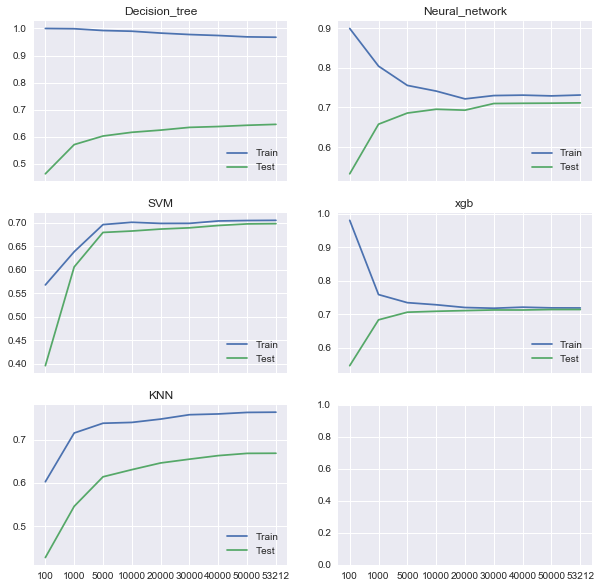

In [175]:
f, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True)
counter = 0
for model in model_dict:
    ax_x = counter/2
    ax_y = counter%2
    axes[ax_x][ax_y].plot(range(len(size_list)),train_score_dict[model], label = "Train" )
    axes[ax_x][ax_y].plot(range(len(size_list)),test_score_dict[model], label = "Test" )
    axes[ax_x][ax_y].set_title(model)
    axes[ax_x][ax_y].legend(loc = "lower right")
    counter += 1
    #plt.title(model + "Learning Rate chart")
plt.xticks(range(len(size_list)),size_list)
plt.legend()

## Model Performance with Iterations

We only estimate the performance for Neutral Netowrk and xgboost model. The KNN and decision tree models don't have this parameter to test. For SVM, we will just allow the algorithm estimator to converge after several iterations. Number of iterations are important variables to tune for neutral network and xgboost. Usually, if the number of iteration numbers is too high, the algorithm takes too long to run. If the number of iterations is too long, the algorithm will be underfitting. We can try to estimate the best number of iterations in this section.

__Neutral Network__
Since sklearn neutral network has the build-in function of loss_curve. It can clearly see that the model loss become relatively flat when number of iterations is larger than 60.

__Gradient Boosting__
For xgboost, we can clearly see the model performance become flat when the number of iterations is higher than 100.

In [28]:
#Xgboost
iterations = [1,30, 60, 70, 100, 120, 150, 170, 200]
train_iteration_list = []
test_iteration_list = []
start_time = timer(None)
for i in iterations:
    model_dict["xgb"] = XGBClassifier(n_estimators = i)
    model_dict["xgb"].fit(X_train, y_train)
    trainF1_score = sklearn.metrics.f1_score(y_train, model_dict["xgb"].predict(X_train), average='weighted')
    testF1_score = sklearn.metrics.f1_score(y_test, model_dict["xgb"].predict(X_test), average='weighted')
    train_iteration_list.append(trainF1_score)
    test_iteration_list.append(testF1_score)
timer(start_time)

Time taken: 0 hours 4 minutes and 42.71 seconds.


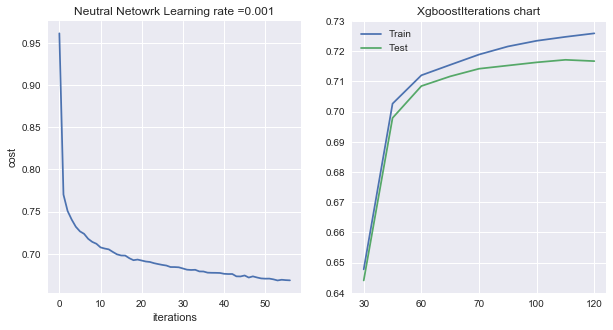

In [30]:
#Neutral Network plot
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(model_dict["Neural_network"].loss_curve_)
axes[0].set_ylabel('cost')
axes[0].set_xlabel('iterations')
axes[0].set_title("Neutral Netowrk Learning rate =" + str(0.001))
#Xgboost plot
axes[1].plot(range(len(iterations)),train_iteration_list, label = "Train" )
axes[1].plot(range(len(iterations)),test_iteration_list, label = "Test" )
axes[1].set_xticklabels(iterations)
axes[1].legend()
axes[1].set_title("Xgboost" + "Iterations chart")

## Hyperparameter Tuning

The following section implements hyperparameter tuning with grid search (random search for xgb because of too much combinations for the parameters). There are a few goals that we want to reach for each algorithm

__Decision Tree__ :
Since decision tree has the overfitting problem, we will tune the max depth of the tree and min samples leaf parameter to tune tree pruning.

In [180]:
min_samples_leafs = [10, 20, 30, 40, 50]
max_depths = [5,10,20,30,50,80]
start_time = timer(None)
DT_clf = GridSearchCV(estimator=model_dict["Decision_tree"], param_grid=dict(min_samples_leaf=min_samples_leafs,max_depth=max_depths),
                      n_jobs=-1, cv = 5, scoring = 'f1_weighted')
DT_clf.fit(X_train, y_train)
timer(start_time)
print DT_clf.best_score_ 


 Time taken: 0 hours 0 minutes and 53.72 seconds.
0.706220441384


__SVM__: For svm we want to which kernel method may works best. We also set the grid search to find the best penalty factor

In [182]:
kernels = ['linear','rbf', 'sigmoid']
Cs = [0.1, 1 ,5, 10]
start_time = timer(None)
svm_clf = GridSearchCV(estimator=model_dict["SVM"], param_grid=dict(kernel = kernels, C = Cs),
                      n_jobs=3, cv = 5, scoring = 'f1_weighted')
svm_clf.fit(X_train, y_train)
timer(start_time)
print svm_clf.best_score_ 


 Time taken: 5 hours 14 minutes and 38.12 seconds.
0.709571822736


__KNN__: KNN also has the problem of overfiting. We will try to increase the n nearst neighbors and the distance metrics.

In [183]:
metrics = ['euclidean','minkowski', 'manhattan']
ns = [2,5, 10, 30, 50]
knn_clf = GridSearchCV(estimator=model_dict["KNN"], param_grid=dict( metric= metrics, n_neighbors = ns),
                      n_jobs=-1, cv = 5, scoring = 'f1_weighted')
knn_clf.fit(X_train, y_train)
print "The best tet score is", knn_clf.best_score_ 
#print knn_clf.best_estimator_

The best tet score is 0.684809975635


__Neutral Network__: To get better performance, we want to see if we are able to get better performance by adding more hidden layers. Since the solver is set to 'adam', the learning rate setting is not very important since it will adjust through the iterations.

In [184]:
hidden_layer_sizes_list = [10, 50, 100, 200]
start_time = timer(None)
NN_clf = GridSearchCV(estimator=model_dict["Neural_network"], param_grid=dict(hidden_layer_sizes =  hidden_layer_sizes_list),
                      n_jobs=-1, cv = 5, scoring = 'f1_weighted')
NN_clf.fit(X_train, y_train)
timer(start_time)
print "The best tet score is",NN_clf.best_score_ 
#print NN_clf.best_estimator_


 Time taken: 0 hours 3 minutes and 59.4 seconds.
The best tet score is 0.716878443987


__XGB__: we are going to tune the learning rate to see if the model can return a better fit. I also try to increase the number of tree and tree depth to see if that can increase the model performance. However, since xgb model takes a long time to train, random search instead of grid search is used to find the best hyperparamters.

In [185]:
params = {'min_child_weight': [1, 5, 10], 'learning_rate': [0.001, 0.01, 0.1, 1, 5], 'n_estimators': [100, 150, 200], 'max_depth': [3, 4, 5]}
xgb = XGBClassifier(objective='multi:softprob',silent=True, nthread=1)
folds = 5
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )
start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)
print "The best tet score is", random_search.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 13.9min finished



 Time taken: 0 hours 14 minutes and 49.48 seconds.
The best tet score is 0.726165793688


The xgb model still get the best score in all algorithms. The next step is to use the best parameter combination of xgb to train the whole training dataset. This will be our final model. The final model performs slightly better than than the default setting.

In [186]:
print "The best tet score is", random_search.best_estimator_

The best tet score is XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=100, nthread=1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [187]:
final_xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=100, nthread=1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [192]:
start_time = timer(None)
final_xgb.fit(X_train, y_train)
trainF1_score = sklearn.metrics.f1_score(y_train, final_xgb.predict(X_train), average='weighted')
testF1_score = sklearn.metrics.f1_score(y_test, final_xgb.predict(X_test), average='weighted')
print "model- xgb" + ": The training set F1 score is "+ str(trainF1_score)
print "model- xgb" + ": The test set F1 score is "+ str(testF1_score)
print "model- xgb" + ": The test set accuracy is "+ str(sklearn.metrics.accuracy_score(y_test, final_xgb.predict(X_test)))
timer(start_time)

model- xgb: The training set F1 score is 0.743240293633
model- xgb: The test set F1 score is 0.723366790207
model- xgb: The test set accuracy is 0.727012590614

 Time taken: 0 hours 1 minutes and 2.47 seconds.


## Feature importance

The age/time/month/sex are the most factors determining the outcome of the model

In [207]:
feature_importance = zip(X_train.columns,final_xgb.feature_importances_)

In [208]:
feature_importance.sort(key=lambda x: x[1], reverse = True)
for i, f in enumerate(feature_importance[:15]):
    print "The ", str(i) , "most important feature is ", f

The  0 most important feature is  ('age_upon_outcome_(years)', 0.19679186)
The  1 most important feature is  ('outcome_hour', 0.16510172)
The  2 most important feature is  ('outcome_month', 0.10837246)
The  3 most important feature is  ('sex_upon_outcome_Neutered Male', 0.031298906)
The  4 most important feature is  ('intake_type_Stray', 0.029342722)
The  5 most important feature is  ('intake_type_Owner Surrender', 0.025039123)
The  6 most important feature is  ('sex_upon_outcome_Spayed Female', 0.02425665)
The  7 most important feature is  ('intake_condition_Normal', 0.023082942)
The  8 most important feature is  ('intake_type_Public Assist', 0.022691706)
The  9 most important feature is  ('animal_type_Dog', 0.021517998)
The  10 most important feature is  ('sex_upon_outcome_Intact Male', 0.02112676)
The  11 most important feature is  ('animal_type_Cat', 0.02112676)
The  12 most important feature is  ('colormuti-color', 0.015258216)
The  13 most important feature is  ('dogbreed_Pit Bul

# Conclusion

In conclusion, we analyze the austin animal shelter data to explore the final outcome of the animal and try to forecast the outcome when the animal is taken to the shelter. To find the best algorithm, we explore 5 different method - KNN, decision tree, Neurtal Network, Xgboost, and SVM. A base model is built up to fit each of the method for a comparison point. To improve the performance of the algorithm, we explore the model performance's relationship with the datasize and the number of iterations. Finally, we use grid search to find the best hyperparameter for each model (the parameter is set to fix problem (underfitting or overfitting) we find in the base model). 

The final model is xgboost model with 100 estimator and a learning rate of 1. We have the F1 score at 0.723. The accuracy of the final model is around the same level. That means, when the animal came to the shelter, there is a 72.7% chance that we predict its final outcome. We also explore the feature importance of the final model and find that the age/time/month/sex are the most factor determining the outcome of the model.

Overally, the running time of model training is not a problem for this question since the data is relatively small. However, it does become an issue when we try to grid search the best paramter for xgboost since it will invoke hundreds of hyperparameter combination, plus the k-fold search. We choose random search in this question. The final result is not ideal but acceptable. If possible, it is better we can add more variables(like animal photos) to the dataset, which can greatly help to improve the prediction(and of course with more investment).